# 2 - PyTorch Workflows

## What we're going to cover

In this module we're going to cover a standard PyTorch workflow (it can be chopped and changed as necessary but it covers the main outline of steps).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

For now, we'll use this workflow to predict a simple straight line but the workflow steps can be repeated and changed depending on the problem you're working on.

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **1. Getting data ready** | Data can be almost anything but to get started we're going to create a simple straight line |
| **2. Building a model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop**. |
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Saving and loading a model** | You may want to use your model elsewhere, or come back to it later, here we'll cover that. |
| **6. Putting it all together** | Let's take all of the above and combine it. |

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.1'

## 1. Data (preparing and loading)

Machine learning is a game of two parts:
1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.




In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

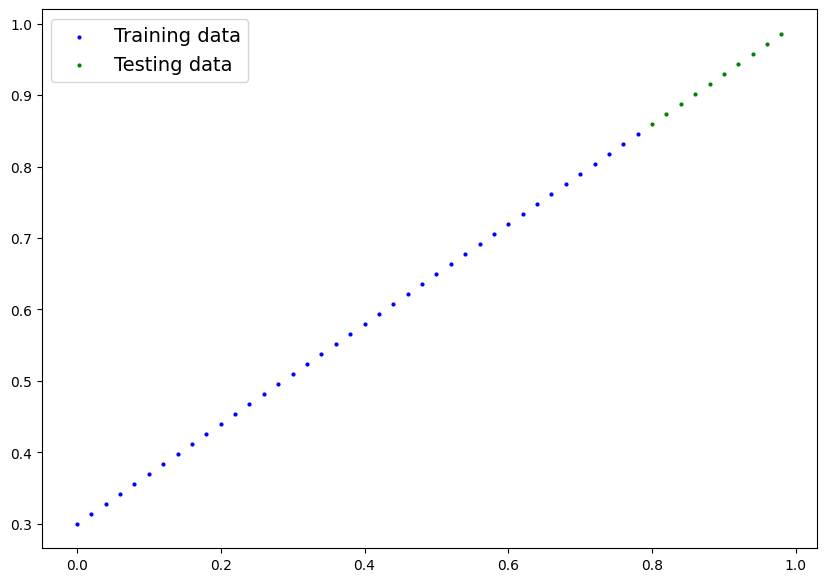

In [6]:
plot_predictions();

Epic!

Now instead of just being numbers on a page, our data is a straight line.

> **Note:** Now's a good time to introduce you to the data explorer's motto... "visualize, visualize, visualize!"
>
> Think of this whenever you're working with data and turning it into numbers, if you can visualize something, it can do wonders for understanding.
>
> Machines love numbers and we humans like numbers too but we also like to look at things.

## 2. Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

We're going to jump right in.

We'll write the code first and then explain everything.

Let's replicate a standard linear regression model using pure PyTorch.

In [7]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1))
        self.bias = nn.Parameter(torch.randn(1)) 

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

Alright there's a fair bit going on above but let's break it down bit by bit.

> **Resource:** We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, I'd recommend reading [Real Python's Object Orientating programming in Python 3 guide](https://realpython.com/python3-object-oriented-programming/) a few times.



### PyTorch model building essentials


| PyTorch module | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html#parameter) | Stores tensors that can be used with `nn.Module`. If `requires_grad=True` gradients (used for updating model parameters via [**gradient descent**](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html))  are calculated automatically, this is often referred to as "autograd".  |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). |
| `def forward()` | All `nn.Module` subclasses require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module` (e.g. the linear regression formula above).


### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using [`.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters).

In [8]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model contains) of the model using [`.state_dict()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict).

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`
To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

In [10]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [11]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


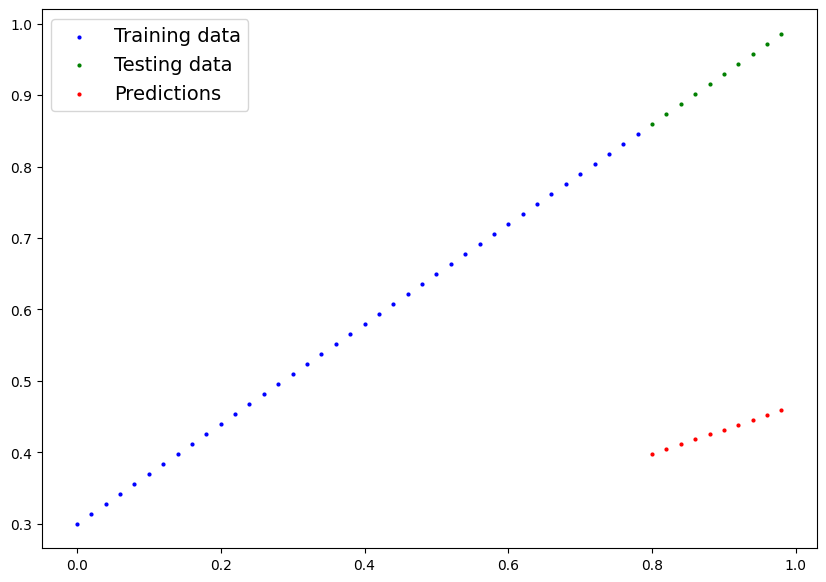

In [12]:
plot_predictions(predictions=y_preds)

In [13]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to *parameters* as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.


In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Set up an optimzer
optimizer = torch.optim.SGD(
    params=model_0.parameters(), 
    lr=0.01)

### Building a traning & testing loop in PyTorch

A couple of things we need in a training loop
1. Loop through the data
2. Forward pass (this involves data moving through our model's `forward()` to make predictions on data - also called forward propogation
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimzier zero grad
5. Loss backward - move backwards throught the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropogration**)
6. Optimizer step- use of optimizers to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [17]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 500

epoch_count = []
train_loss_values = []
test_loss_values = []

### TRAINING
# Loop through the data
for epoch in range(epochs):
    # Set the model to traning mode
    model_0.train() # Train mode in PyTorch sets all params that require gradients to require gradients
    
    # Forward pass
    y_pred = model_0(X_train)
    
    # Loss function
    loss = loss_fn(y_pred, y_train)
    
    # Optimzier zero grad
    optimizer.zero_grad()

    # Backpropgration
    loss.backward()

    # Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if (epoch % 10 == 0):
        epoch_count.append(epoch)
        train_loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test Loss: {test_loss}", end="\n####\n\n")
        

Epoch: 0 | Test: 0.31288138031959534 | Test Loss: 0.48106518387794495
####

Epoch: 10 | Test: 0.1976713240146637 | Test Loss: 0.3463551998138428
####

Epoch: 20 | Test: 0.08908725529909134 | Test Loss: 0.21729660034179688
####

Epoch: 30 | Test: 0.053148526698350906 | Test Loss: 0.14464017748832703
####

Epoch: 40 | Test: 0.04543796554207802 | Test Loss: 0.11360953003168106
####

Epoch: 50 | Test: 0.04167863354086876 | Test Loss: 0.09919948130846024
####

Epoch: 60 | Test: 0.03818932920694351 | Test Loss: 0.08886633068323135
####

Epoch: 70 | Test: 0.03476089984178543 | Test Loss: 0.0805937647819519
####

Epoch: 80 | Test: 0.03132382780313492 | Test Loss: 0.07232122868299484
####

Epoch: 90 | Test: 0.02788740023970604 | Test Loss: 0.06473556160926819
####

Epoch: 100 | Test: 0.024458957836031914 | Test Loss: 0.05646304413676262
####

Epoch: 110 | Test: 0.021020209416747093 | Test Loss: 0.04819049686193466
####

Epoch: 120 | Test: 0.01758546754717827 | Test Loss: 0.04060482233762741
###

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [19]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

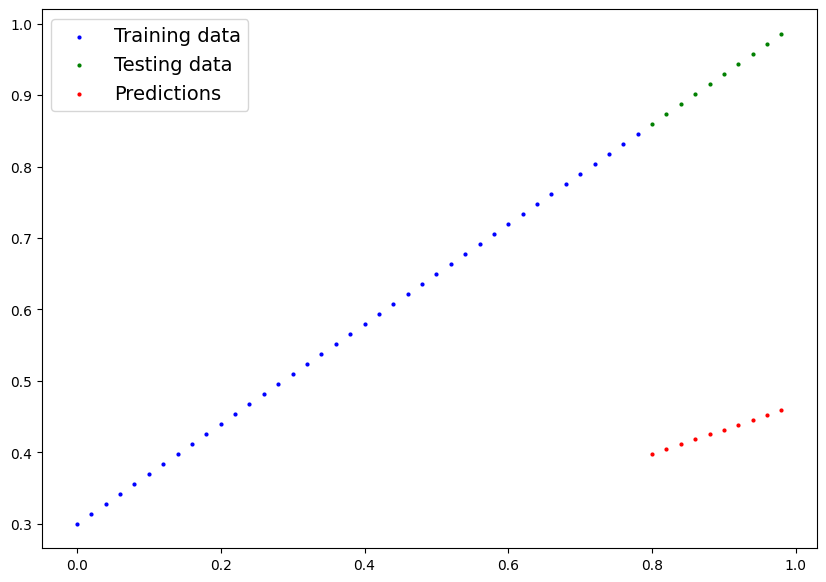

In [20]:
plot_predictions(predictions=y_preds)

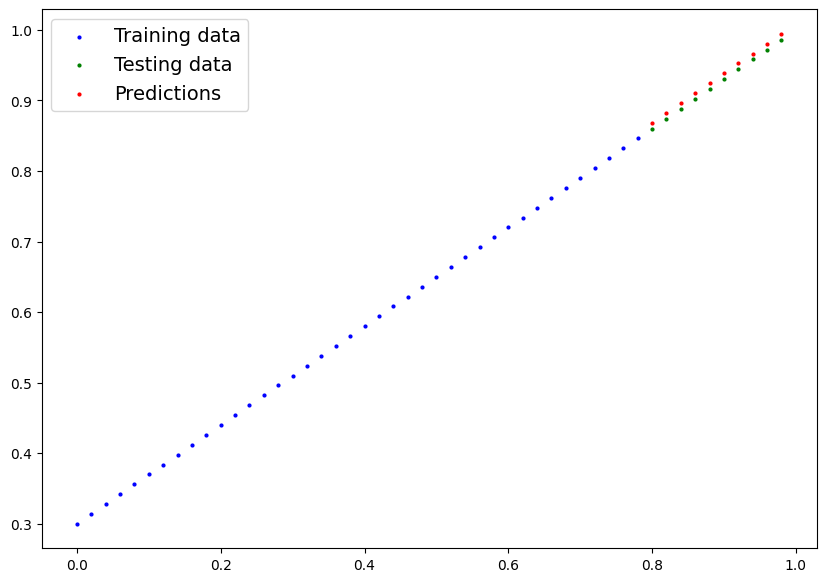

In [21]:
plot_predictions(predictions=y_preds_new)

In [22]:
epoch_count[:10]

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [23]:
train_loss_values[:10]

[tensor(0.3129, grad_fn=<MeanBackward0>),
 tensor(0.1977, grad_fn=<MeanBackward0>),
 tensor(0.0891, grad_fn=<MeanBackward0>),
 tensor(0.0531, grad_fn=<MeanBackward0>),
 tensor(0.0454, grad_fn=<MeanBackward0>),
 tensor(0.0417, grad_fn=<MeanBackward0>),
 tensor(0.0382, grad_fn=<MeanBackward0>),
 tensor(0.0348, grad_fn=<MeanBackward0>),
 tensor(0.0313, grad_fn=<MeanBackward0>),
 tensor(0.0279, grad_fn=<MeanBackward0>)]

In [24]:
test_loss_values[:10]

[tensor(0.4811),
 tensor(0.3464),
 tensor(0.2173),
 tensor(0.1446),
 tensor(0.1136),
 tensor(0.0992),
 tensor(0.0889),
 tensor(0.0806),
 tensor(0.0723),
 tensor(0.0647)]

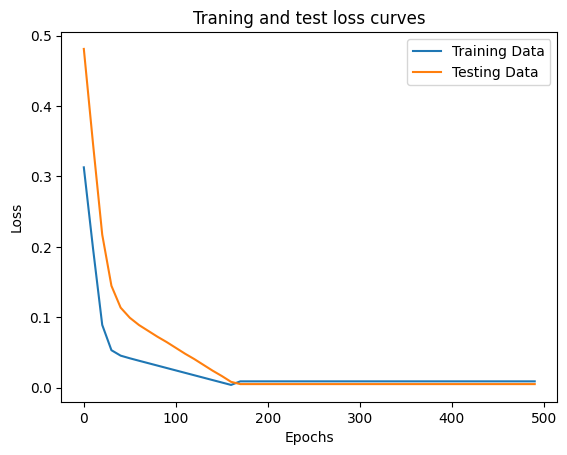

In [25]:
import numpy as np 

plt.plot(epoch_count, np.array(torch.tensor(train_loss_values).numpy()), label="Training Data")
plt.plot(epoch_count, test_loss_values, label="Testing Data")
plt.title("Traning and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [26]:
# Saving a model in PyTorch
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Saving model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)


Saving model to models/01_pytorch_workflow_model_0.pth


In [27]:
# Loading the saved model

loaded_model_0 = LinearRegressionModel()

# Load the saved state dict of model_0 (this will updatr the new instance with updated params)

loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [28]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [29]:
# Make some predictions with out loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [30]:
# make some model preds
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)


y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])